In [5]:
# All necessary imports
import os
import difflib
import graphviz
import owlready2 as owl

In [2]:
onto_path = 'file://' + os.path.abspath('ontologies/gistCore9.5.0')
onto = owl.get_ontology(onto_path).load()
print('Loaded owl file at:', onto_path)

Loaded owl file at: file:///Users/lawrence/ontologies/gistCore9.5.0


In [6]:
#create a list of all classes
classes=list(onto.classes())

In [ ]:
print ('All classes\n' + '-' * 20)
for x in classes: 
    print(x)
print()

In [4]:
# Get a random class in collection
cls = classes[-10]
print (cls)

gist.SystemInstant


In [6]:
#It appears that each class has a dictionary listing  associated with it
print(cls.__dict__)
print()
# specifically it has an ontology, a namespace, name, _is_a, _equivalent_to etc

{'namespace': get_ontology("https://ontologies.semanticarts.com/o/gistCore#").get_namespace("https://ontologies.semanticarts.com/gist/"), 'storid': 519, '_name': 'SystemInstant', 'is_a': [owl.Thing], '_equivalent_to': None, '__module__': 'owlready2.entity', '__doc__': None}



In [7]:
# this is how to look up the dictionary for that aspect
print('name(string):', cls.name)

name(string): SystemInstant


In [26]:
cls.is_a

[owl.Thing]

In [27]:
print('module_type:', cls.__module__)

module_type: owlready2.entity


In [29]:
print('equivalent_to:', cls.equivalent_to)

equivalent_to: [gist.TimeInstant & gist.hasPrecision.value(gist._one_millisecond)]


In [7]:
#Another way of finding the class I want. And assigning it the name whatever_class
Project_class=onto.search(iri='*Project*')
print(Project_class)

[gist.Project]


In [18]:
Project_class[0].is_a

[owl.Thing]

In [22]:
onto.search(subclass_of=Project_class[0])

[gist.Project]

In [43]:
for sc in Project_class[0].ancestors():
    print (sc)
for sc in Project_class[0].descendants():
    print (sc)

owl.Thing
gist.Project
gist.Project


In [ ]:
# Retrieve all object properties
properties = list(onto.object_properties())

In [ ]:
print('\nAll object properties\n'+'-'*20)
for x in properties: 
    print(x)
print()

In [24]:
rel = properties[-1]
print(rel)
print(rel.__dict__)
print()

gist.viableRange
{'namespace': get_ontology("https://ontologies.semanticarts.com/o/gistCore#").get_namespace("https://ontologies.semanticarts.com/gist/"), 'is_a': [owl.ObjectProperty], 'storid': 599, '_name': 'viableRange', '_equivalent_to': None, '__module__': 'owlready2.entity', '__doc__': None, '_domain': None, '_range': None, '_property_chain': None, '_inverse_property': None, '_python_name': 'viableRange', '_class_property_type': [], '_class_property_some': True, '_class_property_only': False, '_class_property_relation': False, '_inverse_storid': 0}



In [26]:
"""
The .class_property_type attribute of Properties allows to indicate how to handle class properties:
    “some”: handle class properties as existential restrictions (i.e. SOME restrictions and VALUES restrictions).
    “only”: handle class properties as universal restrictions (i.e. ONLY restrictions).
    “relation”: handle class properties as relations (i.e. simple RDF triple, as in Linked Data).
"""
print('class_property_some:', rel._class_property_some)
print('class_property_only:', rel._class_property_only)
print('class_property_relation:', rel._class_property_relation)

class_property_some: True
class_property_only: False
class_property_relation: False


In [25]:
print('name(string):', rel.name)
print('module_type:', rel.__module__)
print('is_a:', rel.is_a)
print()

name(string): viableRange
module_type: owlready2.entity
is_a: [owl.ObjectProperty]



In [32]:
#Interested in the relation 'affects'
governedBy_property=onto.search(iri='*governedBy*')

In [33]:
print(governedBy_property[0])
print('class_property_some:', governedBy_property[0]._class_property_some)
print('class_property_only:', governedBy_property[0]._class_property_only)
print('class_property_relation:', governedBy_property[0]._class_property_relation)

gist.governedBy
class_property_some: True
class_property_only: False
class_property_relation: False


In [ ]:
# Retrieve all disjoint sets
disjoints = list(onto.disjoints())
print('\nAll disjoints\n'+'-'*20)
for x in disjoints: 
    # NOTE: Retreive all disjoint individual entity objects, stored in the dict
    print(x)
    print(x.__dict__)
    print()

## Part 4: Higher-level API exploration
Some helper functions to retrieve useful info given an entity to search for. This is a mimic of ontograf plugin feature from Protege.

In [8]:
# Default type2str from owlready2
type2str_restriction = owl.class_construct._restriction_type_2_label

def _process_entity(entity, job_name, orig_entity, graph):
    """Helper: Append entity for the specified job.
    """
    edge = (orig_entity, job_name, entity)
    if edge not in graph:
        graph.append(edge)
    return graph

def _process_restriction(restriction, entity, graph):
    """Helper: Append restriction.
    """
    assert restriction.__module__ == 'owlready2.class_construct'
    
    # Grab object_property --type--> value
    object_property, value = restriction.property, restriction.value
    restriction_type = type2str_restriction[restriction.type]
    
    # Separate logical or for 'only'
    if restriction_type == 'only':
        for or_value in value.Classes:
            edge = (entity, '{},{}'.format(object_property.name, restriction_type), or_value)
            if edge not in graph:
                graph.append(edge)
            
    # No more processing for 'some'
    else:
        edge = (entity, '{},{}'.format(object_property.name, restriction_type), value)
        if edge not in graph:
            graph.append(edge)
        
    return graph

def _process_subclasses(entity, graph):
    """Helper: Append subclasses.
    """
    # Safely grab all subclasses
    try:
        subclses = list(entity.subclasses())
    except:
        subclses = []

    for subcls in subclses:
        if (entity, 'has_subclass', subcls) not in graph:
            graph.append((entity, 'has_subclass', subcls))
        if (subcls, 'subclass_of', entity) not in graph:
            graph.append((subcls, 'subclass_of', entity))

    return graph

def _populate_subclass_rel(graph):
    """Helper: Ensure 'subclass_of' and 'has_subclass' always appear in pairs.
    """
    for edge in graph:
        if edge[1] == 'subclass_of' and (edge[2], 'has_subclass', edge[0]) not in graph:
            graph.append((edge[2], 'has_subclass', edge[0]))
        elif edge[1] == 'has_subclass' and (edge[2], 'subclass_of', edge[0]) not in graph:
            graph.append((edge[2], 'subclass_of', edge[0]))
    return graph

def _process_instances(entity, graph):
    """Helper: Append individuals.
    """
    # Safely grab all individuals
    try:
        instances = entity.instances()
    except:
        instances = []

    for instance in instances:
        if instance.is_a[0] == entity:
            if (entity, 'has_individual', instance) not in graph:
                graph.append((entity, 'has_individual', instance))

    return graph

def generate_knowledge_graph(entity):
    """Helper function to grab entity-relation from onto and 
    return as knowledge graph.
    """
    graph = []

    # Part 1: Append subclasses
    graph = _process_subclasses(entity, graph)

    # Part 2: Collect equivalent_to
    try:
        equivalent_to_list = entity.INDIRECT_equivalent_to  # NOTE: Weird bug here, have to use INDIRECT
    except:
        equivalent_to_list = []
    for et in equivalent_to_list:
        # equivalent_to AND objects:
        if et.__module__ == 'owlready2.class_construct':
            for x in et.Classes:
                # For class restriction, retrieve relevant infos inside
                if x.__module__ == 'owlready2.class_construct':
                    graph = _process_restriction(x, entity, graph)
                    
    # Part 3: Look into is_a
    is_a_list = entity.is_a
    for x in is_a_list:
        # Entity: is_a indicates subclasses
        if x.__module__ == 'owlready2.entity':
            graph = _process_entity(x, 'subclass_of', entity, graph)
                
        # Restriction
        elif x.__module__ == 'owlready2.class_construct':
            graph = _process_restriction(x, entity, graph)
        
    # Part 4: Look into instances
    graph = _process_instances(entity, graph)
    
    # Part 5: Some additional filters
    graph = _populate_subclass_rel(graph)
    
    return graph

def _filter_graph(graph, onto):
    """Helper: filter graph from some ill-logical entries.
    """
    filtered_graph = []
    # Grab all individuals
    individuals = list(onto.individuals())

    for edge in graph:
        passed = True
        # Ill-logical individuals
        if edge[0] in individuals:
            passed = False
        if passed:
            filtered_graph.append(edge)
    return filtered_graph

def keyword_search_onto(keyword, onto):
    """Search and index key entity from onto given keyword.
    """
    classes = list(onto.classes())
    classes_str = [x.name for x in classes]
    all_res = difflib.get_close_matches(keyword, classes_str)
    # Only grab the most probable search keyword
    if len(all_res) > 0:
        res = all_res[0]
        return classes[classes_str.index(res)]
    else:
        return None

def _to_string(graph):
    """Helper: Convert everything collected inside graph list into
    string.
    """
    for i in range(len(graph)):
        edge = list(graph[i])
        for k in range(len(edge)):
            if type(edge[k]) is not str:
                edge[k] = edge[k].name
            edge[k] = edge[k].replace(',', ', ')
        graph[i] = (edge[0], edge[1], edge[2])
    return graph

def ontograf_simple(orig_entity, onto):
    """Interface func to search and retrieve infor for a given
    entity inside onto.
    """
    if orig_entity is None:
        return []
    
    # Initial graph search
    graph = generate_knowledge_graph(orig_entity)
    
    # Prep for other key entities given the initial graph
    entities = []
    for edge in graph:
        entities.append(edge[2])

    # 1st-level of filters, append more info from children and parent nodes
    for entity in entities:
        sub_graph = generate_knowledge_graph(entity)
        for edge in sub_graph:
            if edge[2] == orig_entity:
                if (entity, edge[1], orig_entity) not in graph and entity != orig_entity:
                    graph.append((entity, edge[1], orig_entity))

    # 2nd-level of filters, filter some ill-logical nodes
    graph = _filter_graph(graph, onto)

    # Convert everything inside graph into str
    graph = _to_string(graph)

    return graph

In [9]:
def convert_to_graphviz(graph, name='KG'):
    """Helper function to convert edge graph into graphviz.Digraph.
    """
    e = graphviz.Digraph(name)
    e.attr('node', shape='box')
    for edge in graph:
        e.attr('node', shape='box')
        e.node(edge[0])
        e.node(edge[2])
        e.edge(edge[0], edge[2], label=edge[1])
    return e

--------------------
False gist.Project
[('Project', 'hasSubTask, some', 'Task')]


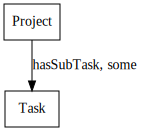

In [11]:
print('-'*20)
entity = keyword_search_onto('Project', onto)
print(entity == onto.Thing, entity)
kg = ontograf_simple(entity, onto)
print(kg)
convert_to_graphviz(kg)

--------------------
False gist.Project
[('Project', 'hasSubTask, some', 'Task')]


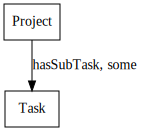

In [27]:
print('-'*20)
entity = keyword_search_onto('Project', onto)
print(entity == onto.Project, entity)
kg = ontograf_simple(entity, onto)
print(kg)
convert_to_graphviz(kg)

In [28]:
print('-'*20)
entity = keyword_search_onto('bottle', onto)
print(entity == onto.Bottle, entity)
kg = ontograf_simple(entity, onto)
print(kg)
convert_to_graphviz(kg)

--------------------
True None
[]


--------------------
False gist.Task
[('Task', 'hasGoal, some', 'Intention')]


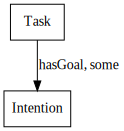

In [29]:
print('-'*20)
entity = keyword_search_onto('Task', onto)
print(entity == onto.Task, entity)
kg = ontograf_simple(entity, onto)
print(kg)
convert_to_graphviz(kg)

--------------------
False gist.Intention
[('Intention', 'has_subclass', 'Function'), ('Function', 'subclass_of', 'Intention'), ('Intention', 'has_subclass', 'Requirement'), ('Requirement', 'subclass_of', 'Intention'), ('Intention', 'has_subclass', 'Goal'), ('Goal', 'subclass_of', 'Intention')]


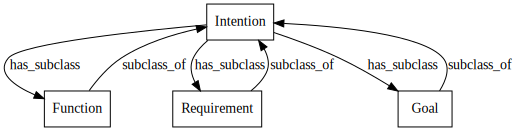

In [30]:
print('-'*20)
entity = keyword_search_onto('Intention', onto)
print(entity == onto.Intention, entity)
kg = ontograf_simple(entity, onto)
print(kg)
convert_to_graphviz(kg)

In [20]:
print('-'*20)
entity = keyword_search_onto('glassbottle', onto)
print(entity == onto.HumanHand, entity)
kg = ontograf_simple(entity, onto)
print(kg)
convert_to_graphviz(kg)

--------------------
True None
[]


In [21]:
print('-'*20)
entity = keyword_search_onto('cold', onto)
print(entity == onto.HumanHand, entity)
kg = ontograf_simple(entity, onto)
print(kg)
convert_to_graphviz(kg)

--------------------
True None
[]


In [16]:
print('-'*20)
entity = keyword_search_onto('hello', onto)
print(entity == onto.HumanHand, entity)
kg = ontograf_simple(entity, onto)
print(kg)
convert_to_graphviz(kg)

--------------------
True None
[]
